# Generate several sets of normal and non-normal samples <a class="tocSkip">

In this notebook, we create several datasets consisting of normal and non-normal samples. The sets are named $\mathcal{A}-\mathcal{E}$ and generated and described in the following sections.

## Set up the environment

In [1]:
import os
import pathlib
import pickle

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

import util

Read the configuration.

In [2]:
# Define the path to the configuration dictionary
config_path = 'configuration.p'

# Load the configuration dictionary
with open(config_path, 'rb') as f:
    configuration = pickle.load(f)
    
# Get the path to the directory to which the datasets will be stored
data_directory_path = configuration['data']['directory_path']

## Set $\mathcal{A}$

The samples consist of $10, 20, \ldots, 100$ elements. 

The normal samples are drawn from a a normal distributions $N(\mu,\sigma^2)$ whose location parameter ($\mu$) is randomly selected from the range $[-100,100]$ and the standard deviation is randomly drawn from the range $[1, 20]$. For each $n$, a total of $L$ normal distributions are defined and a sample of size $n$ is drawn from each of them.

The non-normal samples are drawn from the Pearson family of distributions. Each distribution is specified by its first four moments. The mean and standard deviation are determined the same as for the normal samples. They are combined with the skewness ($s$) and kurtosis ($k$) that range over $\{\}$ and $\{\}$ and fulfill the following two conditions: (1) $k - s^2 - 1 \geq 0$ and (2) $\neg(s=0 \land k=3)$. The first condition is a limitation known from theory. The second requirement is there to ensure that those non-normal distributions are sufficiently different from the normal ones, since for normal distributions it holds that $s = 0$ and $k = 3$. A sample is drawn from each such distribution.

The set is balanced. It contains $13050$ normal and $13050$ non-normal samples.

In [3]:
# Define the ranges for the sample sizes 
# and non-normal skewness and kurtosis in the set A
n_range = range(10, 101, 10)
s_range = [x/10.0 for x in range(-300, 301, 5)] # skewness range -300, 301, 5;-150, 151, 5;-805, 810, 5
k_range = [x/10.0 for x in range(0, 401, 5)]   # kurtosis range 0, 401, 5;0, 201, 5;0, 1610, 5

# Let M denote the number of non-normal samples drawn from the same distribution.
# Since the set is created as balanced, M will influence the number of normal samples
# in the set. See the function generate_dataset for details.
M = 1

# Create a function that generates datasets
def generate_dataset(n_range, s_range, k_range, M, verbose=True):
    # Generate non-normal samples
    nonnormal_samples = util.generate_pearson_nonnormal_samples(s_range, k_range, n_range, M)

    # Calculate L, the number of normal samples of the same size
    L = len(nonnormal_samples) // len(n_range)
            
    # Generate L normal samples of size n for each n in n_range
    normal_samples = util.generate_normal_samples(n_range, L)

    # Print how many samples were generated
    if verbose:
        print("Normal samples: ", len(normal_samples))
        print("Non-normal samples: ", len(nonnormal_samples))

    # Label the sets
    normal_samples = util.label_samples(normal_samples, 1)
    nonnormal_samples = util.label_samples(nonnormal_samples, 0)

    # Unify them
    all_samples = normal_samples + nonnormal_samples
    
    return all_samples

In [4]:
set_A = generate_dataset(n_range, s_range, k_range, M)

Normal samples:  13050
Non-normal samples:  13050


Describe the dataset, update the configuration dictionary, and save the set.

In [5]:
# Create a function to describe the set, save it and update the configuration dictionary
def describe_and_save(all_samples, set_name, n_range):
    global data_directory_path
    global configuration
    
    # Describe the set
    metadata = {
        'name' : set_name,
        'n_range' : n_range,
        'number_of_normal' : len([sample for sample in all_samples if sample[-1] == 1]),
        'number_of_nonnormal' : len([sample for sample in all_samples if sample[-1] == 0]),
        'path' : os.path.join(data_directory_path, '{}.data'.format(set_name))
    }

    # Add it to the configuration dictionary
    configuration['data']['datasets'][set_name] = metadata

    # Save the set to a file
    path = metadata['path']
    util.save_to_file(all_samples, path)
    print("Saved to the file", path)

describe_and_save(set_A, 'A', n_range)

Saved to the file data/A.data


In [6]:
def inspect_dataset(samples):
    dimensions = ['skewness', 'kurtosis', 'standard_deviation']
    desc = {label: {dimension : [] for dimension in dimensions} for label in [0, 1]}

    for i in range(len(samples)):
        sample = samples[i][:-1]
        label = samples[i][-1]
        skewness = stats.skew(sample)
        kurtosis = stats.kurtosis(sample, fisher=False)
        sd = stats.tstd(sample)
        desc[label]['skewness'].append(skewness)
        desc[label]['kurtosis'].append(kurtosis)
        desc[label]['standard_deviation'].append(sd)
    
    return desc

In [7]:
desc_A = inspect_dataset(set_A)

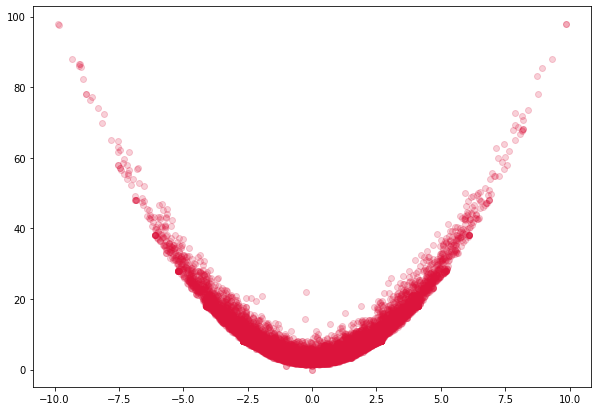

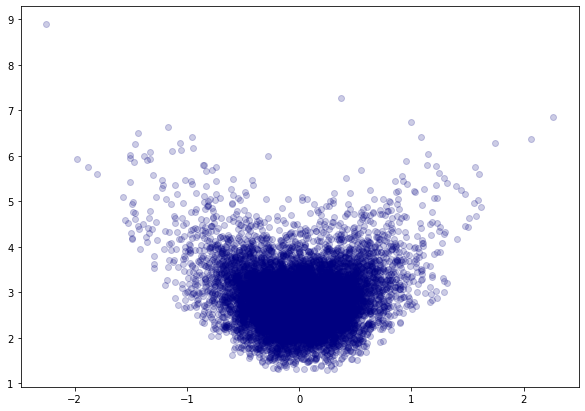

In [8]:
colors = ['crimson', 'navy']
for label in desc_A:
    #ax = Axes3D(fig)
    fig = plt.figure(figsize=(10, 7))
    plt.scatter(desc_A[label]['skewness'], 
                desc_A[label]['kurtosis'], alpha=0.2, color=colors[label])
                #desc[label]['standard_deviation'])
    #plt.xlim(-2, 2)
    #plt.ylim(0, 10)

## Set $\mathcal{B}$

This set differs from $\mathcal{A}$ only in the sizes of the samples. They contain contain $5, 15, \ldots, 95$ elements. Everything else is completely the same as in the set $\mathcal{A}$.

In [9]:
# Define the ranges for the sample sizes 
# and non-normal skewness and kurtosis in the set A
n_range = range(5, 101, 10) 
s_range = [x/10.0 for x in range(-300, 301, 5)] # skewness range -150, 151, 5;-805, 810, 5
k_range = [x/10.0 for x in range(0, 401, 5)]   # kurtosis range 0, 201, 5;0, 1610, 5

# Let M denote the number of non-normal samples drawn from the same distribution
M = 1

set_B = generate_dataset(n_range, s_range, k_range, M)
describe_and_save(set_B, 'B', n_range)

Normal samples:  13050
Non-normal samples:  13050
Saved to the file data/B.data


## Set $\mathcal{C}$

This set contains non-normal samples whose sizes are $10, 20, \ldots, 100$.

The non-normal distributions from which the samples are drawn are hand-picked and are usually used to assess the empirical power of normality tests. They are clssified into four groups. $G_1, G_2, G_3$ and $G_4$. See the paper for more details. For each sample size $n \in \left\{10, 20, \ldots, 100\right\}$, $L=10000$ samples are drawn from each group.

Define the distributions.

In [10]:
# Define the distributions from group G1
logistic = lambda n: stats.logistic.rvs(size = n)
laplace = lambda n: stats.laplace.rvs(size = n)
t1 = lambda n: stats.t.rvs(1, size = n)
t3 = lambda n: stats.t.rvs(3, size = n)

# Define the distributions from group G2
gumbel1 = lambda n: list(np.random.gumbel(loc=0, scale=1, size=n))
gumbel2 = lambda n: list(np.random.gumbel(loc=0, scale=2, size=n))
gumbel3 = lambda n: list(np.random.gumbel(loc=0, scale=0.5, size=n))

# Define the distributions from group G3
expon = lambda n: stats.expon.rvs(loc = 1, size = n)
gamma1 = lambda n: list(np.random.gamma(2, scale = 1, size = n))
gamma2 = lambda n: list(np.random.gamma(0.5, scale = 1, size = n))
lognormal1 = lambda n: list(np.random.lognormal(mean = 0, sigma = 1, size = n))
lognormal2 = lambda n: list(np.random.lognormal(mean = 0, sigma = 2, size = n))
lognormal3 = lambda n: list(np.random.lognormal(mean = 0, sigma = 0.5, size = n))
weibull1 = lambda n: stats.weibull_min.rvs(0.5, scale = 1, size = n)
weibull2 = lambda n: stats.weibull_min.rvs(2, scale = 1, size = n)

# Define the distributions from group G4
uniform = lambda n: list(np.random.uniform(low = 0, high = 1, size = n))
beta1 = lambda n: np.random.beta(2, 2, size = n)
beta2 = lambda n: np.random.beta(0.5, 0.5, size = n)
beta3 = lambda n: np.random.beta(3, 1.5, size = n)
beta4 = lambda n: np.random.beta(2, 1, size = n)

# Let groups be a dictionary containing distributions from four groups G1-G4
groups = {
    1 : [logistic, laplace, t1, t3],
    2 : [gumbel1, gumbel2, gumbel3],
    3 : [expon, gamma1, gamma2, lognormal1, lognormal2, lognormal3, weibull1, weibull2],
    4 : [uniform, beta1, beta2, beta3, beta4]
}

Generate the set, save it and update the configuration dictionary.

In [11]:
# Define the range of sample sizes
n_range = range(10, 101, 10)

# Define L, which denotes how many samples with n elements
# will be drawn from each group.
L = 10000

set_C = {}

for g in groups:
    # Select a group
    group = groups[g]
    
    # Prepare the storage to hold the samples from this group
    samples = []
    
    # Draw the samples
    for n in n_range:
        # Initialize the counter of the samples generated so far in this group
        so_far = 0
        
        # Iterate over the distributions in the group until L samples are generated
        d = 0
        while so_far <= L:
            # Get the distribution whose turn is to generate a sample
            dist = group[d]
            
            # Generate a sample
            sample = dist(n)
            
            # Store it
            samples.append(sample)
            
            # Increase the counters
            so_far = so_far + 1
            d = d + 1
            
            # Return to the first distribution in the group and start over
            if d == len(group):
                d = 0
    
    # Label the samples as non-normal
    samples = util.label_samples(samples, 0)
    
    # Describe the set
    set_name = 'C-G{}'.format(g)
    filename = '{}.data'.format(set_name)
    
    group_metadata = {
        'name' : set_name,
        'n_range' : n_range,
        'number_of_normal' : 0,
        'number_of_nonnormal' : len(samples),
        'path' : os.path.join(data_directory_path, filename)
    }

    # Add it to the configuration dictionary
    configuration['data']['datasets'][set_name] = group_metadata
                
    # Save the samples
    path = group_metadata['path']
    util.save_to_file(samples, path)
    print("Saved {} to the file {}".format(set_name, path))
    
    set_C[set_name] = samples

Saved C-G1 to the file data/C-G1.data
Saved C-G2 to the file data/C-G2.data
Saved C-G3 to the file data/C-G3.data
Saved C-G4 to the file data/C-G4.data


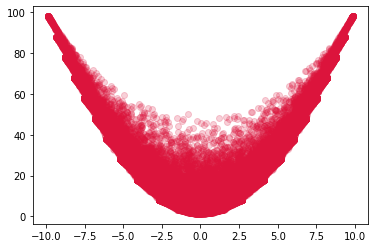

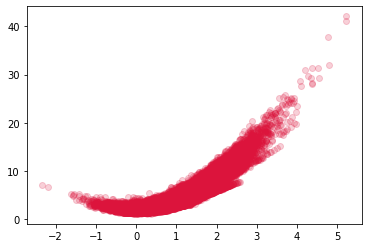

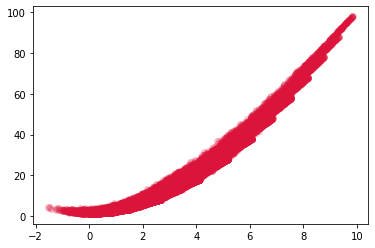

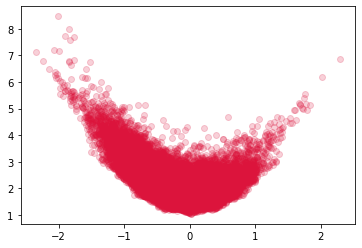

In [12]:
for group_name in set_C:
    desc = inspect_dataset(set_C[group_name])
    for label in desc:
        if label == 0:
            fig = plt.figure()
            plt.scatter(desc[label]['skewness'],
                        desc[label]['kurtosis'],
                        alpha=0.2,
                        color='crimson')
        

## Set $\mathcal{D}$

Create it the same way as the set $\mathcal{A}$.

In [13]:
# Define the ranges for the sample sizes 
# and non-normal skewness and kurtosis 
n_range = range(10, 101, 10)
s_range = [x/10.0 for x in range(-300, 301, 5)] # skewness range -150, 151, 5;-805, 810, 5
k_range = [x/10.0 for x in range(0, 401, 5)]   # kurtosis range 0, 201, 5;0, 1610, 5

# Let M denote the number of non-normal samples drawn from the same distribution.
# Since the set is created as balanced, M will influence the number of normal samples
# in the set. See the function generate_dataset for details.
M = 1

# Generate and register the set
set_D = generate_dataset(n_range, s_range, k_range, M)
describe_and_save(set_D, 'D', n_range)

Normal samples:  13050
Non-normal samples:  13050
Saved to the file data/D.data


## Set $\mathcal{E}$

Generate it the same way as $\mathcal{A}$, but with more samples.

In [14]:
# Define the ranges for the sample sizes 
# and non-normal skewness and kurtosis 
n_range = range(10, 101, 10)
s_range = [x/10.0 for x in range(-300, 301, 5)] # skewness range -150, 151, 5;-805, 810, 5
k_range = [x/10.0 for x in range(0, 401, 5)]   # kurtosis range 0, 201, 5;0, 1610, 5

# Let M denote the number of non-normal samples drawn from the same distribution.
# Since the set is created as balanced, M will influence the number of normal samples
# in the set. See the function generate_dataset for details.
M = 5

# Generate and register the set
set_E = generate_dataset(n_range, s_range, k_range, M)
describe_and_save(set_E, 'E', n_range)

Normal samples:  65250
Non-normal samples:  65250
Saved to the file data/E.data


## Save the changes to the configuration dictionary

In [15]:
with open(config_path, 'wb') as f:
    pickle.dump(configuration, f)